In [16]:
import warnings
warnings.filterwarnings("ignore")
from make_predictions import make_predictions
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path

import pandas as pd

from settings import PROCESSED_DATA_DIR

matches_df = pd.read_csv(Path(PROCESSED_DATA_DIR, 'bundesliga_matches.csv'))

exclude_cols = ['team', 'opponent', 'date', 'venue', 'target']
cols_to_fill = [col for col in matches_df.columns if col not in exclude_cols]
matches_df[cols_to_fill] = matches_df[cols_to_fill].fillna(matches_df[cols_to_fill].mean())


# move date,team, opponent, venue, target to the front
# cols = matches_df.columns.tolist()
# cols = cols[-5:] + cols[:-5]
# matches_df = matches_df[cols]

test_df = matches_df[matches_df['date'] >= '2023-11-10']
train_df = matches_df[matches_df['date'] < '2023-11-10']

from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.impute import SimpleImputer
from reduce_memory_usage import reduce_memory_usage

# Copy and preprocess the DataFrame
temp_df = matches_df.copy()
temp_df = reduce_memory_usage(temp_df)
temp_df = temp_df.select_dtypes(['number'])
x = temp_df.drop('target', axis=1)
y = temp_df['target']
x = x.select_dtypes(exclude=['object'])

exclude_cols = ['team', 'opponent', 'date', 'venue', 'target']
cols_to_fill = [col for col in matches_df.columns if col not in exclude_cols]
matches_df[cols_to_fill] = matches_df[cols_to_fill].fillna(matches_df[cols_to_fill].mean())

matches_df.drop(columns=['team', 'opponent', 'venue'], axis=1, inplace=True)

# Handle NaN values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
x_imputed = imputer.fit_transform(x)

best_percentile = 0
best_precision = 0
best_predictors = []
best_model = None

for percentile in range(5, 101, 5):
    selector = SelectPercentile(f_classif, percentile=percentile)

    # Fit and transform the imputed data
    x_new = selector.fit_transform(x_imputed, y)

    # Get selected feature indices
    selected_indices = selector.get_support(indices=True)

    # Get selected column names
    selected_columns = x.columns[selected_indices]

    # Check if matches_df has a column with rolling avg       at '2023-11-10' I GET 100%%%
    precision, model = make_predictions(matches_df, selected_columns, cutoff_date='2023-11-10')

    print(f'Precision: {precision} with percentile: {percentile}')

    if precision > best_precision:
        best_precision = precision
        best_percentile = percentile
        best_predictors = selected_columns
        best_model = model

print('----------------------------------')
print(f'Best precision: {best_precision} with percentile: {best_percentile}')
print(f'Len of predictors: {len(best_predictors)}')
print(f'Best predictors: ')
print(best_predictors.tolist())

Memory usage of dataframe is 4.538646697998047 MB
Memory usage of dataframe after reduction 1.1289539337158203 MB
Reduced by 75.12575864929538 % 
Train: 3771 matches (99.52%)
Test: 18 matches (0.48%)
Precision: 40.00%
Precision: 0.4 with percentile: 5
Train: 3771 matches (99.52%)
Test: 18 matches (0.48%)
Precision: 66.67%
Precision: 0.6666666666666666 with percentile: 10
Train: 3771 matches (99.52%)
Test: 18 matches (0.48%)
Precision: 75.00%
Precision: 0.75 with percentile: 15
Train: 3771 matches (99.52%)
Test: 18 matches (0.48%)
Precision: 66.67%
Precision: 0.6666666666666666 with percentile: 20
Train: 3771 matches (99.52%)
Test: 18 matches (0.48%)
Precision: 66.67%
Precision: 0.6666666666666666 with percentile: 25
Train: 3771 matches (99.52%)
Test: 18 matches (0.48%)
Precision: 75.00%
Precision: 0.75 with percentile: 30
Train: 3771 matches (99.52%)
Test: 18 matches (0.48%)
Precision: 75.00%
Precision: 0.75 with percentile: 35
Train: 3771 matches (99.52%)
Test: 18 matches (0.48%)
Prec

# 100% Precision? Why?
### By Stoyan Kostadinov (4092384)
### For 'AI for Society' minor

## Introduction

My personal project this semester is about predicting football match outcomes. Until now I have gathered 7 Bundesliga seasons of data which equates to over 1800 mathes. I have used this data to train a `RandomForestClassifier` model which predicts the outcome of a match based on the past performance of the two teams (goals, assists, saves, passes, etc...). The model has achieved 100% precision in predicting the outcome of 9 test cases. This is a very interesting result and makes me wonder why this is the case. I will investigate this issue in this project.

The importance of finding out why the model achieves 100% precision is that it will help me understand the data better and will allow me to see how the model works under the hood.

> Important note: The dataset contains two rows of data for each match. One for the home team and one for the away team.

### Main Question

**Why does the `RandomForestClassifier` achieve 100% precision in predicting football match outcomes with a dataset of 3771 samples and 18 test cases?

## Dataset Overview



In [17]:
# Show matches ordered by date.
test_df.sort_values(by='date').head(20)

,gf_rolling_avg,ga_rolling_avg,xg_rolling_avg,xga_rolling_avg,poss_rolling_avg,attendance_rolling_avg,shooting_standard_sh_rolling_avg,shooting_standard_sot_rolling_avg,shooting_standard_sot%_rolling_avg,shooting_standard_g/sh_rolling_avg,...,opponent_code,venue_code,hour,day_code,month_code,target,date,team,opponent,venue
3788,1.666667,2.333333,1.466667,1.500000,52.666667,28611.333333,14.666667,5.000000,34.533333,0.093333,...,18,0,20,4,11,0,2023-11-10,Wolfsburg,Monchengladbach,Away
2635,2.000000,2.333333,1.166667,2.133333,44.666667,45413.666667,9.000000,3.666667,40.966667,0.166667,...,26,1,20,4,11,1,2023-11-10,Monchengladbach,Wolfsburg,Home
3254,1.666667,1.666667,2.533333,1.166667,66.000000,30070.666667,16.000000,5.000000,32.400000,0.130000,...,6,1,15,5,11,1,2023-11-11,Stuttgart,Dortmund,Home
2423,1.666667,1.666667,0.800000,1.233333,40.333333,39305.047093,11.666667,3.000000,27.366667,0.123333,...,5,0,15,5,11,0,2023-11-11,Mainz 05,Darmstadt 98,Away
2211,1.333333,2.666667,1.866667,2.366667,52.333333,48593.333333,17.666667,6.000000,29.200000,0.030000,...,4,0,18,5,11,0,2023-11-11,Koln,Bochum,Away
2033,2.000000,2.666667,1.600000,2.333333,42.666667,37833.333333,10.666667,5.000000,51.200000,0.190000,...,1,0,15,5,11,0,2023-11-11,Hoffenheim,Augsburg,Away
276,3.000000,1.666667,2.166667,1.633333,40.666667,30766.666667,11.333333,4.000000,45.366667,0.270000,...,15,1,15,5,11,0,2023-11-11,Augsburg,Hoffenheim,Home
996,1.333333,2.333333,1.933333,1.933333,55.000000,73076.666667,17.333333,3.333333,19.000000,0.083333,...,23,0,15,5,11,0,2023-11-11,Dortmund,Stuttgart,Away
784,0.666667,4.333333,1.266667,2.966667,53.666667,36873.333333,13.666667,3.666667,29.566667,0.023333,...,17,1,15,5,11,0,2023-11-11,Darmstadt 98,Mainz 05,Home
776,1.666667,1.666667,1.366667,1.133333,44.666667,25903.333333,11.000000,3.333333,31.600000,0.130000,...,16,1,18,5,11,0,2023-11-11,Bochum,Koln,Home


In [18]:
# Show distribution of target column.
test_df['target'].value_counts()

target
0    13
1     5
Name: count, dtype: int64

In [19]:
# Show the matches with target = 1 since this is what the precision is based on.
test_df[test_df['target'] == 1].sort_values(by='date')

,gf_rolling_avg,ga_rolling_avg,xg_rolling_avg,xga_rolling_avg,poss_rolling_avg,attendance_rolling_avg,shooting_standard_sh_rolling_avg,shooting_standard_sot_rolling_avg,shooting_standard_sot%_rolling_avg,shooting_standard_g/sh_rolling_avg,...,opponent_code,venue_code,hour,day_code,month_code,target,date,team,opponent,venue
2635,2.000000,2.333333,1.166667,2.133333,44.666667,45413.666667,9.000000,3.666667,40.966667,0.166667,...,26,1,20,4,11,1,2023-11-10,Monchengladbach,Wolfsburg,Home
700,5.000000,0.333333,3.600000,0.933333,55.666667,39305.047093,18.666667,9.666667,50.266667,0.266667,...,13,1,15,5,11,1,2023-11-11,Bayern Munich,Heidenheim,Home
3254,1.666667,1.666667,2.533333,1.166667,66.000000,30070.666667,16.000000,5.000000,32.400000,0.130000,...,6,1,15,5,11,1,2023-11-11,Stuttgart,Dortmund,Home
488,2.333333,1.333333,1.433333,1.333333,60.333333,29759.000000,13.333333,5.333333,43.866667,0.196667,...,24,1,15,6,11,1,2023-11-12,Bayer Leverkusen,Union Berlin,Home
2909,3.000000,1.000000,2.200000,1.400000,57.333333,31463.333333,15.000000,6.666667,42.666667,0.166667,...,9,1,19,6,11,1,2023-11-12,RB Leipzig,Freiburg,Home


<Axes: ylabel='count'>

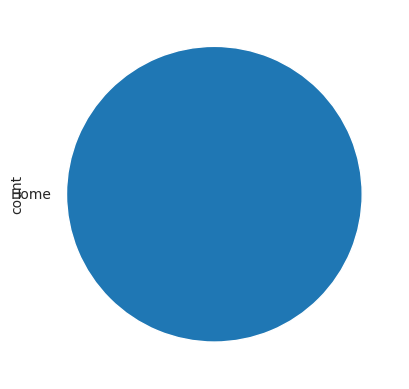

In [20]:
# Show a pie chart of venue distribution for target = 1.
test_df[test_df['target'] == 1]['venue'].value_counts().plot.pie()

Bundesliga rankings (as of 2023-11-10):
1. Bayer Leverkusen
2. Bayern Munich
3. Stuttgart
4. Dortmund
5. RB Leipzig
6. Hoffenheim
7. Eintracht Frankfurt
8. Wolfsburg
9. SC Freiburg
10. Augsburg
11. Monchengladbach
12. Werder Bremen
13. Heidenheim
14. Bochum
15. Darmstadt
16. Mainz
17. Union Berlin
18. Koln

| Home Team | Away Team | Home Team Rank | Away Team Rank |
|-----------|-----------|----------------|----------------|
| Bayern    | Heidenheim| 2              | 13             |
| Stuttgart | Dortmund  | 3              | 4              |
| Leverkusen| Union     | 1              | 17             |
| Leipzig   | Freiburg  | 5              | 9              |
| Gladbach  | Wolfsburg | 11             | 8              |

Monchengladbach vs Wolfsburg [pre-match insights](https://www.google.com/search?channel=fs&client=ubuntu-sn&q=bundesliga+standings#sie=m;/g/11kqnvpr32;2;/m/037169;tl;fp;1;;;):

1. Borussia Mönchengladbach are unbeaten in their last seven competitive meetings with Wolfsburg (W3, D4 – all Bundesliga) since a 2-1 away loss in December 2019. It is currently the Foals’ best streak against a current Bundesliga club.
2. Borussia Mönchengladbach have made their worst start to a Bundesliga season after 10 games (10 points) for 13 years. Gladbach only had six points at this stage in 2010/11, when they survived relegation via the play-off.
3. VfL Wolfsburg are without a win in four Bundesliga games (D1, L3) for the first time since January/February of this year. Only Union Berlin have picked up fewer points over the last four matchdays (0) than the Wolves (1).

## Visualizing the model

In [26]:
estimator = best_model.estimators_[0]
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator,
                out_file='010-tree.dot',
                feature_names=best_predictors,
                filled=True,
                rounded=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', '010-tree.dot', '-o', '010-tree.png', '-Gdpi=600'])

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.139776 to fit


0

In [29]:
# show monchengladbach vs wolfsburg
outlier = test_df[(test_df['team'] == 'Monchengladbach') & (test_df['opponent'] == 'Wolfsburg')][best_predictors]
outlier

,gf_rolling_avg,ga_rolling_avg,xg_rolling_avg,xga_rolling_avg,poss_rolling_avg,attendance_rolling_avg,shooting_standard_sh_rolling_avg,shooting_standard_sot_rolling_avg,shooting_standard_sot%_rolling_avg,shooting_standard_g/sh_rolling_avg,...,misc_performance_fls_rolling_avg,misc_performance_off_rolling_avg,misc_performance_og_rolling_avg,misc_performance_recov_rolling_avg,misc_aerial_duels_won_rolling_avg,misc_aerial_duels_lost_rolling_avg,misc_aerial_duels_won%_rolling_avg,team_code,opponent_code,venue_code
2635,2.0,2.333333,1.166667,2.133333,44.666667,45413.666667,9.0,3.666667,40.966667,0.166667,...,8.333333,1.666667,0.0,55.333333,15.666667,18.666667,45.1,18,26,1


In [51]:
print(outlier['passing_1/3_rolling_avg'])
print(outlier['passing_total_cmp_rolling_avg'])
print(outlier['passing_xag_rolling_avg'])
print(outlier['venue_code'])
print(outlier['passing_short_cmp_rolling_avg'])
print(outlier['opponent_code'])
print(outlier['keeper_performance_saves_rolling_avg'])
print(outlier['possession_take-ons_succ_rolling_avg'])
print(outlier['passing_total_att_rolling_avg'])
print(outlier['possession_carries_cpa_rolling_avg'])
print(outlier['passing_ast_rolling_avg'])
print(outlier['passing_medium_cmp_rolling_avg'])
print(outlier['passing_long_cmp%_rolling_avg'])
print(outlier['misc_aerial_duels_won_rolling_avg'])
print(outlier['passing_short_cmp_rolling_avg'])

2635    24.333333
Name: passing_1/3_rolling_avg, dtype: float64
2635    393.0
Name: passing_total_cmp_rolling_avg, dtype: float64
2635    0.833333
Name: passing_xag_rolling_avg, dtype: float64
2635    1
Name: venue_code, dtype: int64
2635    160.333333
Name: passing_short_cmp_rolling_avg, dtype: float64
2635    26
Name: opponent_code, dtype: int64
2635    4.333333
Name: keeper_performance_saves_rolling_avg, dtype: float64
2635    8.666667
Name: possession_take-ons_succ_rolling_avg, dtype: float64
2635    498.0
Name: passing_total_att_rolling_avg, dtype: float64
2635    4.666667
Name: possession_carries_cpa_rolling_avg, dtype: float64
2635    1.0
Name: passing_ast_rolling_avg, dtype: float64
2635    187.333333
Name: passing_medium_cmp_rolling_avg, dtype: float64
2635    50.666667
Name: passing_long_cmp%_rolling_avg, dtype: float64
2635    15.666667
Name: misc_aerial_duels_won_rolling_avg, dtype: float64
2635    160.333333
Name: passing_short_cmp_rolling_avg, dtype: float64


## Conclusion
- All 5 guessed matches are played at home.
- 4 of the 5 guessed matches are against teams with a lower rank.
- The outlier is Monchengladbach vs Wolfsburg but Monchengladbach has been consistently performing better than Wolfsburg in the past 7 matches.